# LDA model on oncology

provider_type: surgical, hematology, gynecological, radiation, medical
- filter out least and most common hcpcs_codes (compared to model 1, which does no filtering)
- only consider in-facility claims
- number of topics = 13
- include all oncology specialties

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

from gensim import matutils, models, corpora

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = """SELECT npi, provider_type, hcpcs_code, hcpcs_description, bene_day_srvc_cnt
FROM payments WHERE provider_type LIKE '%Oncology' and place_of_service='F'"""
payments = pd.read_sql_query(q, con=con)

In [4]:
payments.shape

(92477, 5)

In [5]:
payments['provider_type'].unique()

array(['Hematology/Oncology', 'Medical Oncology', 'Surgical Oncology',
       'Radiation Oncology', 'Gynecological/Oncology'], dtype=object)

## construct raw dataframe

In [6]:
## out of facility claims
by_npi = (payments[['npi','hcpcs_code','bene_day_srvc_cnt']].
                pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
                fillna(value=0))

In [7]:
by_npi.shape

(14098, 670)

## preprocess dataframe

### filter out extreme hcpcs_code columns (top 10 claimed codes and codes with only 1 claim)

In [23]:
## What are the counts for the top claimed codes?
counts_per_code = (payments['hcpcs_code'].value_counts().
                   reset_index(name='count').
                   rename(columns={'index': 'hcpcs_code'}))

pd.set_option('max_colwidth', 80)
counts_per_code = (counts_per_code.merge(payments[['hcpcs_code', 'hcpcs_description']],
                                         on='hcpcs_code', sort=False)
                   .drop_duplicates())

top_codes_to_drop = list(counts_per_code['hcpcs_code'][:10])
counts_per_code.head(15)

,hcpcs_code,count,hcpcs_description
0,99232,6667,"Subsequent hospital inpatient care, typically 25 minutes per day"
6667,99214,6126,"Established patient office or other outpatient, visit typically 25 minutes"
12793,99223,6060,"Initial hospital inpatient care, typically 70 minutes per day"
18853,99233,5638,"Subsequent hospital inpatient care, typically 35 minutes per day"
24491,99213,5631,"Established patient office or other outpatient visit, typically 15 minutes"
30122,99205,4526,"New patient office or other outpatient visit, typically 60 minutes"
34648,99215,3906,"Established patient office or other outpatient, visit typically 40 minutes"
38554,99222,3310,"Initial hospital inpatient care, typically 50 minutes per day"
41864,99204,2977,"New patient office or other outpatient visit, typically 45 minutes"
44841,99231,2863,"Subsequent hospital inpatient care, typically 15 minutes per day"


In [24]:
## How many codes have been claimed only once?
bottom_codes_to_drop = list(counts_per_code.query('count == 1')['hcpcs_code'])
len(bottom_codes_to_drop)

225

In [19]:
counts_per_code.tail(10)

,hcpcs_code,count,hcpcs_description
92467,44180,1,Release of small bowel scar tissue using an endoscope
92468,74246,1,X-ray of upper digestive tract with contrast
92469,57268,1,Repair of protrusion of intestine into rectum or vagina
92470,49585,1,Repair of hernia at navel patient age 5 years or older
92471,44050,1,Incisional repair of twisted or herniated small bowel
92472,50327,1,Preparation of donor kidney for transplantation
92473,13151,1,"Repair of wound (1.1 to 2.5 centimeters) of eyelids, nose, ears, and/or lips"
92474,23078,1,Removal (5 centimeters or greater) tissue growth of shoulder area
92475,50398,1,Change of kidney drainage tube
92476,77799,1,Administration of radiation therapy


In [22]:
## so total columns dropped is:
print('number of cols to drop: {0}'.format(len(bottom_codes_to_drop) + len(top_codes_to_drop)))

number of cols to drop: 235


In [25]:
by_npi.drop(labels=(top_codes_to_drop + bottom_codes_to_drop), axis=1, inplace=True)
by_npi.shape

(14098, 435)

###  drop doctors who have less than 2 claims

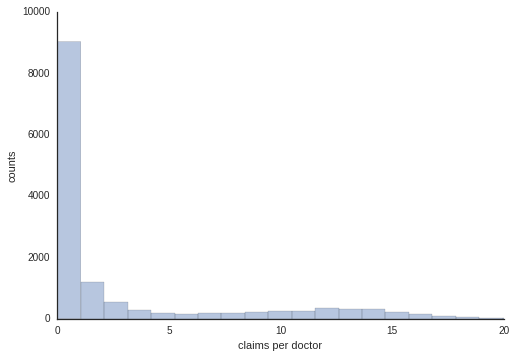

In [26]:
## How many different drug codes have been claimed per doctor?  Plot distribution

#number_of_codes_per_doctor = (by_npi > 0.0).sum(axis = 1)
g = sns.distplot((by_npi > 0.0).sum(axis = 1), kde=False, bins=80)
g.set(xlim=(0,20), xlabel='claims per doctor', ylabel='counts')
sns.despine()

In [35]:
# number of docs to drop (docs who have < 2 claims, based on the already column-filtered dataframe)
sum((by_npi > 0.0).sum(axis = 1) < 2)

9031

In [36]:
by_npi = by_npi[(by_npi > 0.0).sum(axis = 1) > 1]

In [37]:
by_npi.shape

(5067, 435)

In [38]:
by_npi.to_csv("11d_by_npi_reduced_oncology_dataframe.csv")

## LDA on filtered data frame using 10 topics

In [39]:
corpus = matutils.Dense2Corpus(by_npi.as_matrix(), documents_columns=False)

In [40]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [41]:
time0 = time.time()
ldamodel = models.ldamodel.LdaModel(corpus_tfidf, num_topics=10, passes=20)
print('calculated in {0}s'.format(time.time()-time0))

calculated in 73.47537875175476s


In [42]:
## Save model
ldamodel.save("11d_lda_10topics_colsDropped_docsDropped_oncology.model", pickle_protocol=3)

## Interpret the 10 topics in the model

In [43]:
## top 15 words in each topic
topics_matrix = ldamodel.show_topics(formatted=False, num_words=15)

In [44]:
## for each topic, store indices of top 20 hcpcs_codes in a list
topic_idx_dict = {}

for i in topics_matrix:
    topic_idx_dict[i[0]] = [int(word[0]) for word in i[1]]

In [45]:
## for each topic's list of indexes, get the list of hcpcs_codes
topic_dict = {}

for k, v in topic_idx_dict.items():
    topic_dict[k] = [by_npi.columns.values[i] for i in v]

In [46]:
## Topic 0
t = 0
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
1360,70450,CT scan head or brain
1361,71010,"X-ray of chest, 1 view, front"
1362,71020,"X-ray of chest, 2 views, front and side"
1380,74177,CT scan of abdomen and pelvis with contrast
2117,58558,Biopsy and/or removal of polyp of the uterus using an endoscope
2320,36561,Insertion of central venous catheter and implanted device for infusion benea...
2321,38747,Removal of abdominal organ lymph nodes
2324,77001,"Fluoroscopic guidance for insertion, replacement or removal of central venou..."
3229,85060,Blood smear interpretation by physician with written report
3579,58552,"Vaginal removal of uterus (250 grams or less), tubes, and/or ovaries using a..."


In [47]:
## Topic 1
t = 1
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
9,19301,Partial removal of breast
10,38525,"Biopsy or removal of lymph nodes of under the arm, open procedure"
11,38900,Lymph node imaging during surgery
33,99203,"New patient office or other outpatient visit, typically 30 minutes"
172,99239,"Hospital discharge day management, more than 30 minutes"
508,92511,Examination of the nose and throat using an endoscope
2379,99291,"Critical care delivery critically ill or injured patient, first 30-74 minutes"
2797,99306,"Initial nursing facility visit, typically 45 minutes per day"
2882,19303,Total removal of breast
3361,99356,Prolonged inpatient or observation hospital service first hour


In [48]:
## Topic 2
t = 2
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
33,99203,"New patient office or other outpatient visit, typically 30 minutes"
36,99212,"Established patient office or other outpatient visit, typically 10 minutes"
43,99238,"Hospital discharge day management, 30 minutes or less"
172,99239,"Hospital discharge day management, more than 30 minutes"
183,99221,"Initial hospital inpatient care, typically 30 minutes per day"
412,38221,Needle or trocar bone marrow biopsy
419,G0364,Bone marrow aspiration performed with bone marrow biopsy through the same in...
499,99354,Prolonged office or other outpatient service first hour
755,60500,Removal or exploration of parathyroid glands
2788,99217,Hospital observation care discharge


In [49]:
## Topic 3
t = 3
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
16,77014,CT scan guidance for insertion of radiation therapy fields
17,77263,"Management of radiation therapy, complex"
18,77280,"Management of radiation therapy simulation, simple"
19,77290,"Management of radiation therapy, simulation, complex"
21,77295,"Management of radiation therapy, 3D"
22,77300,Calculation of radiation therapy dose
23,77301,Management of modulation radiotherapy planning
24,77315,"Isodose radiation therapy plan, complex"
27,77331,Special radiation therapy planning
29,77334,"Radiation treatment devices, design and construction, complex"


In [50]:
## Topic 4
t = 4
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
16,77014,CT scan guidance for insertion of radiation therapy fields
17,77263,"Management of radiation therapy, complex"
18,77280,"Management of radiation therapy simulation, simple"
19,77290,"Management of radiation therapy, simulation, complex"
21,77295,"Management of radiation therapy, 3D"
22,77300,Calculation of radiation therapy dose
23,77301,Management of modulation radiotherapy planning
24,77315,"Isodose radiation therapy plan, complex"
27,77331,Special radiation therapy planning
29,77334,"Radiation treatment devices, design and construction, complex"


In [51]:
## Topic 5
t = 5
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
369,G0101,Cervical or vaginal cancer screening; pelvic and clinical breast examination
412,38221,Needle or trocar bone marrow biopsy
622,38572,Removal of total lymph nodes of both sides of pelvis and abdominal lymph nod...
623,58150,Abdominal removal of uterus and cervix
624,58571,Abdominal removal of uterus (250 grams or less) with removal of tubes and/or...
771,48150,"Partial removal of pancreas, bile duct and small bowel with connection of pa..."
1888,38220,Bone marrow aspiration
1921,52000,Diagnostic examination of the bladder and bladder canal (urethra) using an e...
2119,58661,Removal of ovaries and/or tubes using an endoscope
4785,20665,Removal of cranial tongs or halo (stabilization device for skull)


In [52]:
## Topic 6
t = 6
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
17,77263,"Management of radiation therapy, complex"
21,77295,"Management of radiation therapy, 3D"
22,77300,Calculation of radiation therapy dose
29,77334,"Radiation treatment devices, design and construction, complex"
33,99203,"New patient office or other outpatient visit, typically 30 minutes"
73,31575,Diagnostic examination of voice box using flexible endoscope
685,77432,"Stereotactic radiation treatment management of brain lesions, complete cours..."
927,77786,"High dose brachytherapy delivery, 2-12 channels"
1387,77285,"Management of radiation therapy, simulation, intermediate"
1391,77310,"Isodose radiation therapy plan, 3 or more ports, single area"


In [53]:
## Topic 7
t = 7
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
17,77263,"Management of radiation therapy, complex"
18,77280,"Management of radiation therapy simulation, simple"
19,77290,"Management of radiation therapy, simulation, complex"
21,77295,"Management of radiation therapy, 3D"
22,77300,Calculation of radiation therapy dose
23,77301,Management of modulation radiotherapy planning
24,77315,"Isodose radiation therapy plan, complex"
27,77331,Special radiation therapy planning
28,77332,"Radiation treatment devices, design and construction, simple"
29,77334,"Radiation treatment devices, design and construction, complex"


In [54]:
## Topic 8
t = 8
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
28,77332,"Radiation treatment devices, design and construction, simple"
342,77328,"Brachytherapy radiation therapy plan (over 10 applications, over 12 brachyth..."
372,76873,Ultrasound of prostate
373,76965,Ultrasonic guidance for administration of radiation therapy
386,77778,"Application of radiation source, complex"
387,77790,"Supervision, handling, loading of radiation"
444,76998,Ultrasonic guidance during surgery
575,58548,"Removal of uterus, cervix, and lymph nodes on both sides of pelvis and aorti..."
1864,19081,Biopsy of breast accessed throught the skin with stereotactic guidance
2005,99308,"Subsequent nursing facility visit, typically 15 minutes per day"


In [55]:
## Topic 9
t = 9
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
33,99203,"New patient office or other outpatient visit, typically 30 minutes"
36,99212,"Established patient office or other outpatient visit, typically 10 minutes"
43,99238,"Hospital discharge day management, 30 minutes or less"
172,99239,"Hospital discharge day management, more than 30 minutes"
183,99221,"Initial hospital inpatient care, typically 30 minutes per day"
412,38221,Needle or trocar bone marrow biopsy
445,99202,"New patient office or other outpatient visit, typically 20 minutes"
527,99211,"Established patient office or other outpatient visit, typically 5 minutes"
1533,99236,"Hospital observation or inpatient care high severity, 55 minutes per day"
1908,93010,Routine electrocardiogram (EKG) using at least 12 leads with interpretation ...


## Plot distribution of providers per topic

In [56]:
## per document (provider), assign topic based on highest-probability topic out of the 10
topic_per_doc = []
for i in corpus_tfidf:
    topic_per_doc.append(np.argmax(np.array(ldamodel.get_document_topics(i))[:,1]))

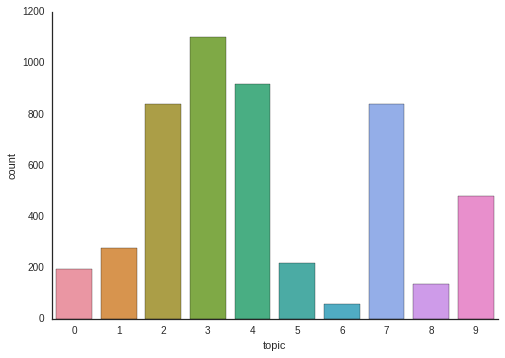

In [57]:
## distribution of providers among topics
ax = sns.countplot(x='topic',data=pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}))
sns.despine()

## Color code distribution over topics by provider_type

In [94]:
color_codes = (pd.DataFrame({'npi':by_npi.index}).
               merge(payments.drop_duplicates('npi')[['npi', 'provider_type']]))

In [95]:
## color code for plotting
len(color_codes)

5067

In [64]:
color_codes.head()

,npi,provider_type
0,1003020660,Surgical Oncology
1,1003027582,Radiation Oncology
2,1003027764,Hematology/Oncology
3,1003068347,Radiation Oncology
4,1003073438,Radiation Oncology


In [68]:
topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}),
                              color_codes], axis=1, ignore_index=True).
                    rename(columns={0:'topic',1:'npi',2:'provider_type'}))

topic_per_doc_df.head()
#topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc), fraud_label], axis=1, ignore_index=True).
#                        rename(columns={0:'topic',1:'fraud'}))

,topic,npi,provider_type
0,1,1003020660,Surgical Oncology
1,3,1003027582,Radiation Oncology
2,9,1003027764,Hematology/Oncology
3,4,1003068347,Radiation Oncology
4,3,1003073438,Radiation Oncology


In [86]:
mydf = (topic_per_doc_df.
        groupby(['topic','provider_type']).
        count().
        rename(columns={'npi':'counts'}).
        reset_index())

In [87]:
mydf.head(10)

,topic,provider_type,counts
0,0,Gynecological/Oncology,31
1,0,Hematology/Oncology,24
2,0,Medical Oncology,4
3,0,Radiation Oncology,61
4,0,Surgical Oncology,74
5,1,Gynecological/Oncology,9
6,1,Hematology/Oncology,56
7,1,Medical Oncology,12
8,1,Radiation Oncology,1
9,1,Surgical Oncology,199


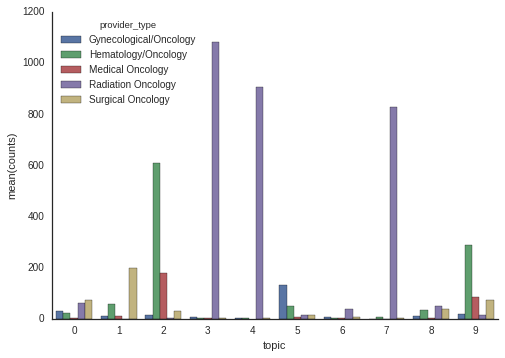

In [77]:
ax = sns.barplot(x='topic', y='counts', hue='provider_type', data=mydf)
sns.despine()

In [88]:
## plot fractions per provider_type rather than absolute counts across topics

## rescale each of the counts by overall total per fraud group
#mydf.groupby(['provider_type']).transform(lambda x: x.sum()['counts'])
types = list(payments['provider_type'].unique())

for t in types:
    mydf.loc[mydf.provider_type == t, 'counts']  = (mydf.loc[mydf.provider_type == t, 'counts'] / 
                                          float(sum(mydf.loc[mydf.provider_type == t, 'counts'])))

mydf.head()

,topic,provider_type,counts
0,0,Gynecological/Oncology,0.129167
1,0,Hematology/Oncology,0.022243
2,0,Medical Oncology,0.013333
3,0,Radiation Oncology,0.020327
4,0,Surgical Oncology,0.165548


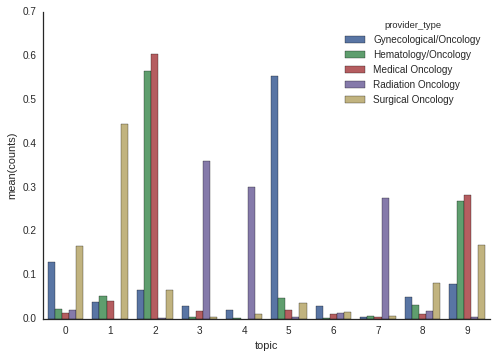

In [89]:
ax = sns.barplot(x='topic', y='counts', hue='provider_type', data=mydf)
sns.despine()

- Looks like radiation oncology is dominating topics 3, 4, and 7.  We can maybe merge all those topics into one => LDA on 8 topics instead of 10.
- Medical Oncology and Hematology/Oncology both dominate topics 2 and 9 in approximately the same fractions.

## Plot doctors in topic space

In [91]:
from sklearn.manifold import TSNE
#from sklearn import preprocessing

In [90]:
topics_per_doc = []

## Get features per doc (probability scores over topics)
for doc in corpus_tfidf:
    topics_per_doc.append(np.array(ldamodel.get_document_topics(doc))[:,1])

by_npi_topics = pd.DataFrame(topics_per_doc)
by_npi_topics.shape

(5067, 10)

In [92]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi_topics.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5067
[t-SNE] Computed conditional probabilities for sample 2000 / 5067
[t-SNE] Computed conditional probabilities for sample 3000 / 5067
[t-SNE] Computed conditional probabilities for sample 4000 / 5067
[t-SNE] Computed conditional probabilities for sample 5000 / 5067
[t-SNE] Computed conditional probabilities for sample 5067 / 5067
[t-SNE] Mean sigma: 0.000004
[t-SNE] Iteration 25: error = 1.7025908, gradient norm = 0.0110100
[t-SNE] Iteration 50: error = 1.6182613, gradient norm = 0.0071308
[t-SNE] Iteration 75: error = 1.2437065, gradient norm = 0.0029636
[t-SNE] Iteration 100: error = 1.1557364, gradient norm = 0.0025979
[t-SNE] Error after 100 iterations with early exaggeration: 1.155736
[t-SNE] Iteration 125: error = 1.0109060, gradient norm = 0.0022064
[t-SNE] Iteration 150: error = 0.9666743, gradient norm = 0.0024278
[t-SNE] Iteration 

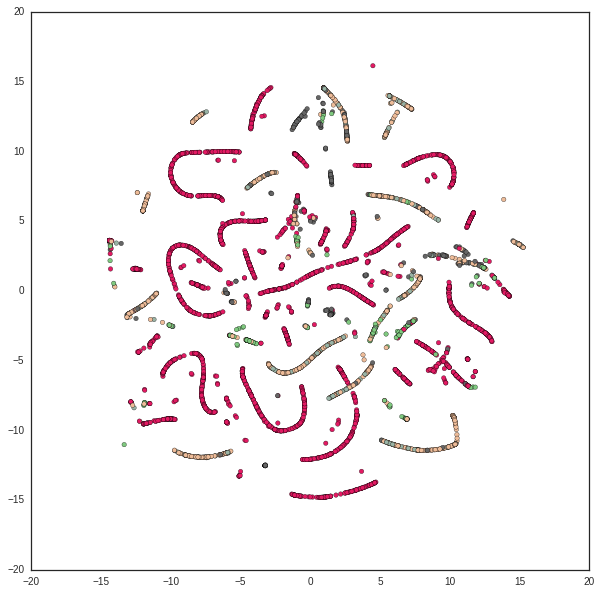

In [125]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(X_embedded[:,0], X_embedded[:,1], 
            c=color_codes.provider_type.astype('category').cat.codes,
            cmap = 'Accent')